In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yaml

In [2]:
with open("data/swiss-reviews-helpful-correct-bigger.txt", 'r') as fp:
    swiss_rev_help = fp.readlines()

In [3]:
len(swiss_rev_help)

23755

In [4]:
swiss_rev_help[0]

'{"reviewerID": "A05423363IP01ZGDN77PM", "asin": "B006TIEY40", "reviewerName": "Francis C.", "helpful": [4, 6], "reviewText": "Have used it for several trips already. Very satisfied. Fits in overhead compartment. Excellent quality and so far durable. Great for overnight trips.", "overall": 5.0, "summary": "Perfect carry-on spinner", "unixReviewTime": 1372032000, "reviewTime": "06 24, 2013"}\n'

In [5]:
def filter_info(line):
    l = line.rstrip('\n')
    l = yaml.load(l)
    if('reviewText' in l.keys()):
        return l['reviewText']
    else:
        return ''

In [ ]:
# Only the review texts
rev_samples = []
for i in range(len(swiss_rev_help)):
    rev_samples.append(filter_info(swiss_rev_help[i]))

In [7]:
# Below to ARI score

In [8]:
import re
import nltk.data
from nltk import wordpunct_tokenize

text = '''There are two ways of constructing a software design:
One way is to make it so simple that there are obviously no deficiencies and
the other way is to make it so complicated that there are no obvious deficiencies.'''
# — C.A.R. Hoare, The 1980 ACM Turing Award Lecture

# split into words by punctuations
# remove punctuations and all '-' words
RE = re.compile('[0-9a-z-]', re.I)
sent = nltk.data.load('tokenizers/punkt/english.pickle')

In [9]:
def get_ARI_score(text):
    words = list(filter(lambda w: RE.search(w) and w.replace('-', ''), wordpunct_tokenize(text)))
    wordc = len(words)
    charc = sum(len(w) for w in words)
    sents = sent.tokenize(text)
    sentc = len(sents)
    return 4.71 * charc / (wordc + 0.1) + 0.5 * (wordc + 0.1) / (sentc + 0.1) - 21.43

In [10]:
# Create the feature dictionary:

In [11]:
def convert_to_dict(line):
    l = line.rstrip('\n')
    l = eval(l)
    return l

In [12]:
dict_list = []
counter = 1
for item in swiss_rev_help:
    if(counter%500 == 0):
        print(counter)
    counter += 1
    dict_list.append(convert_to_dict(item))

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500


In [13]:
features = pd.DataFrame(dict_list)

In [14]:
features.drop(['reviewTime', 'reviewerName', 'unixReviewTime'],inplace=True,axis=1)

In [30]:
features.head(3)

,asin,helpful,overall,reviewText,reviewerID,summary,rev_length,all_caps,sent_count,que_exc_ratio,ari_score,dev_mean_score
0,B006TIEY40,"[4, 6]",5.0,Have used it for several trips already. Very s...,A05423363IP01ZGDN77PM,Perfect carry-on spinner,-0.701678,0.033075,-0.402241,-0.310841,-0.277327,0.467890
1,B006TIEZH6,"[4, 6]",5.0,Have used it for several trips already. Very s...,A05423363IP01ZGDN77PM,Perfect carry-on spinner,-0.701678,0.033075,-0.402241,-0.310841,-0.277327,0.463636
2,B001F42MKG,"[0, 6]",1.0,dont buy this crap. hard to use. doesnt last l...,A05953714NT40ISVAAT5,dont buy this crap,-0.720648,-0.568656,-0.286997,-0.310841,-1.120527,-3.387415


In [16]:
# Review length
features["rev_length"] = features['reviewText'].apply(lambda x: len(x))
features["rev_length"] = (features["rev_length"] - \
                          features["rev_length"].mean()) / features["rev_length"].std()

In [17]:
# Number of all caps
def count_all_caps(text):
    count = 0
    for i in text:
        if(i.isupper()):
            count += 1
    return count/(len(text) + 1)

In [18]:
features["all_caps"] = features['reviewText'].apply(count_all_caps)
features["all_caps"] = (features["all_caps"] - \
                          features["all_caps"].mean()) / features["all_caps"].std()

In [19]:
# Sentence count
features["sent_count"] = features['reviewText'].apply(lambda x: \
                                                      len(nltk.tokenize.sent_tokenize(x)))

In [20]:
features["sent_count"] = (features["sent_count"] - \
                          features["sent_count"].mean()) / features["sent_count"].std()

In [21]:
# Question and exclamation marks ratio to characters
def count_ques_exc_ratio(text):
    count = 0
    for i in text:
        if(i == '!' or i == '?'):
            count += 1
    return count*1.0/(len(text)+1)

In [22]:
features["que_exc_ratio"] = features['reviewText'].apply(count_ques_exc_ratio)
features["que_exc_ratio"] = (features["que_exc_ratio"] - \
                          features["que_exc_ratio"].mean()) / features["que_exc_ratio"].std()

In [23]:
# ARI readability index
features["ari_score"] = features['reviewText'].apply(get_ARI_score)

In [24]:
features["ari_score"] = (features["ari_score"] - \
                          features["ari_score"].mean()) / features["ari_score"].std()

In [25]:
# rating deviation from mean rating score
with open("data/asin_ratings_bigger.json", "r") as fp:
    asin_rev_ratings = fp.readlines()

In [26]:
dict_list_ar = []
for item in asin_rev_ratings:
    dict_list_ar.append(convert_to_dict(item))

In [27]:
dict_ar = dict([(key,d[key]) for d in dict_list_ar for key in d])

In [28]:
def get_dev_mean_score(row):
    if(row['asin'] in dict_ar.keys()):
        return row['overall'] - dict_ar[row['asin']]
    print("Should not get here")
    return 0

In [29]:
features['dev_mean_score'] = features.apply(get_dev_mean_score, axis=1)

In [31]:
# should only be standardized after dev_mean_score has been computed
features["overall"] = (features["overall"] - \
                          features["overall"].mean()) / features["overall"].std()

In [32]:
features["dev_mean_score"] = (features["dev_mean_score"] - \
                          features["dev_mean_score"].mean()) / features["dev_mean_score"].std()

In [33]:
len(features)

23755

In [34]:
features.drop_duplicates(subset=['asin','reviewText'], keep='first', inplace=True)

In [35]:
len(features)

23675

In [36]:
def create_labels(pair):
    if(pair[0]*1.0/pair[1] >= 0.6):
        return 1
    else:
        return 0

In [37]:
features['Y'] = features['helpful'].apply(create_labels)

In [38]:
# Extract tf-idf

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(stop_words='english')
X_train_counts = count_vect.fit_transform(features['reviewText'])

In [40]:
X_train_counts.shape

(23675, 49576)

In [41]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)

In [45]:
X_train_tf.shape

(23675, 49576)

In [43]:
from sklearn.preprocessing import scale, MaxAbsScaler, maxabs_scale

In [44]:
maxabs_scale(X_train_tf, copy=False)

<23675x49576 sparse matrix of type '<class 'numpy.float64'>'
	with 1396844 stored elements in Compressed Sparse Row format>

In [46]:
Y = features.as_matrix(['Y'])

In [47]:
Y.shape

(23675, 1)

In [48]:
X_train_else = features.as_matrix(['overall','rev_length','all_caps','sent_count','que_exc_ratio',
                                   'ari_score', 'dev_mean_score'])

In [49]:
type(X_train_else)

numpy.ndarray

In [50]:
from scipy.sparse import hstack
X = hstack([X_train_tf, X_train_else])

In [51]:
type(X)

scipy.sparse.coo.coo_matrix

In [52]:
X.shape

(23675, 49583)

In [53]:
Y.shape

(23675, 1)

In [54]:
Y = Y.reshape((Y.shape[0],))

In [55]:
Y.shape

(23675,)

In [76]:
sum(features['Y']) # bit more than 3:1 bias towards helpful reviews

17845

In [56]:
# Time for some machine learning

In [57]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, roc_curve

In [58]:
clrf = RandomForestClassifier(n_estimators = 10, class_weight='balanced', n_jobs=-1)

x_tr, x_te, y_tr, y_te = train_test_split(X, Y, train_size=0.8)
clrf.fit(x_tr, y_tr)
print("Test set accuracy:" , clrf.score(x_te, y_te))
print("Train set accuracy:", clrf.score(x_tr, y_tr))

Test set accuracy: 0.825343189018
Train set accuracy: 0.993453009504


In [69]:
cllr = LogisticRegression(class_weight='balanced', n_jobs=-1, C=1)

x_tr, x_te, y_tr, y_te = train_test_split(X, Y, train_size=0.8)
cllr.fit(x_tr, y_tr)
print("Test set accuracy:" , cllr.score(x_te, y_te))
print("Train set accuracy:", cllr.score(x_tr, y_tr))

Test set accuracy: 0.823864836325
Train set accuracy: 0.953590285111


In [74]:
clab = AdaBoostClassifier()

x_tr, x_te, y_tr, y_te = train_test_split(X, Y, train_size=0.8)
clab.fit(x_tr, y_tr)
print("Test set accuracy:" , clab.score(x_te, y_te))
print("Train set accuracy:", clab.score(x_tr, y_tr))

Test set accuracy: 0.812038014784
Train set accuracy: 0.819693769799


In [83]:
# C could be tuned
clsvc = SVC(class_weight='balanced', kernel='linear', probability=True)

#x_tr, x_te, y_tr, y_te = train_test_split(X, Y, train_size=0.8)
#clsvc.fit(x_tr, y_tr)
#print("Test set accuracy:" , clsvc.score(x_te, y_te))
#print("Train set accuracy:", clsvc.score(x_tr, y_tr))

In [ ]:
clrf.fit(x_tr, y_tr)
print("Test set accuracy:" , clsf.score(x_te, y_te))
print("Train set accuracy:", clsf.score(x_tr, y_tr))

In [ ]:
acc = cross_val_score(clrf, X, Y, cv=10, n_jobs=-1)

In [ ]:
acc

In [ ]:
print("Bias: ", 1 - np.mean(acc))
print("variance: ", np.std(acc)**2)

In [ ]:
f1s = cross_val_score(clsf, X, Y, cv=10, scoring='f1', n_jobs=-1)

In [ ]:
f1s

In [ ]:
roc_aucs = cross_val_score(clsf, X, Y, cv=10, scoring='roc_auc', n_jobs=-1)

In [ ]:
roc_aucs

In [ ]:
# Predict values

In [59]:
y_pred_rf = cross_val_predict(clrf, X, Y, cv=10, n_jobs=-1)

In [70]:
y_pred_lr = cross_val_predict(cllr, X, Y, cv=10, n_jobs=-1)

In [77]:
y_pred_ab = cross_val_predict(clab, X, Y, cv=10, n_jobs=-1)

In [ ]:
# takes a bit too long (at least 15 min)
y_pred_svc = cross_val_predict(clsvc, X, Y, cv=10, n_jobs=-1)

In [85]:
cm = confusion_matrix(Y, y_pred_lr)

In [86]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 3859  1971]
 [ 2859 14986]]


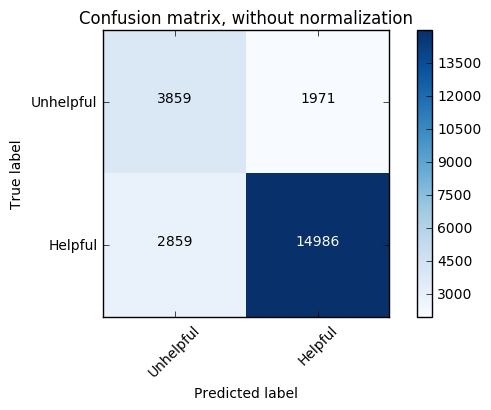

In [87]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=['Unhelpful', 'Helpful'],
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# plot roc-curve

In [88]:
y_pred_lr2 = cllr.predict_proba(X)[:, 1]

In [89]:
y_pred_rf2 = clrf.predict_proba(X)[:, 1]

In [90]:
y_pred_ab2 = clab.predict_proba(X)[:, 1]

In [ ]:
y_pred_svc2 = clsvc.predict_proba(X)[:, 1]

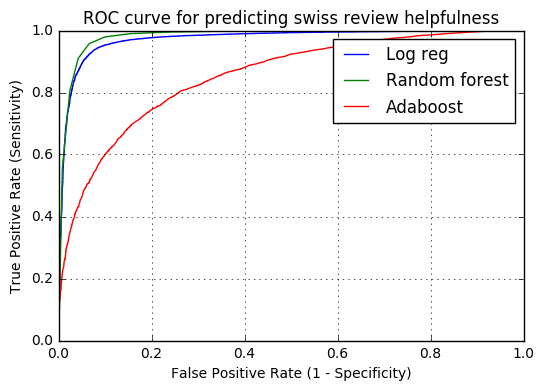

In [92]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr_lr, tpr_lr, thresholds = roc_curve(Y, y_pred_lr2)
fpr_rf, tpr_rf, thresholds = roc_curve(Y, y_pred_rf2)
fpr_ab, tpr_ab, thresholds = roc_curve(Y, y_pred_ab2)
#fpr_svc, tpr_svc, thresholds = roc_curve(Y, y_pred_svc2)
plt.plot(fpr_lr, tpr_lr)
plt.plot(fpr_rf, tpr_rf)
plt.plot(fpr_ab, tpr_ab)
#plt.plot(fpr_svc, tpr_svc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for predicting swiss review helpfulness')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(['Log reg', 'Random forest', 'Adaboost'], loc='upper right')
plt.grid(True)

In [93]:
words_list = count_vect.get_feature_names()
other_feats = ['overall','rev_length','all_caps','sent_count','que_exc_ratio',
                                   'ari_score', 'dev_mean_score']
feature_names = words_list + other_feats

In [101]:
temp_names = []
for i in range(number):
    temp_names.append(feature_names[indices[i]])

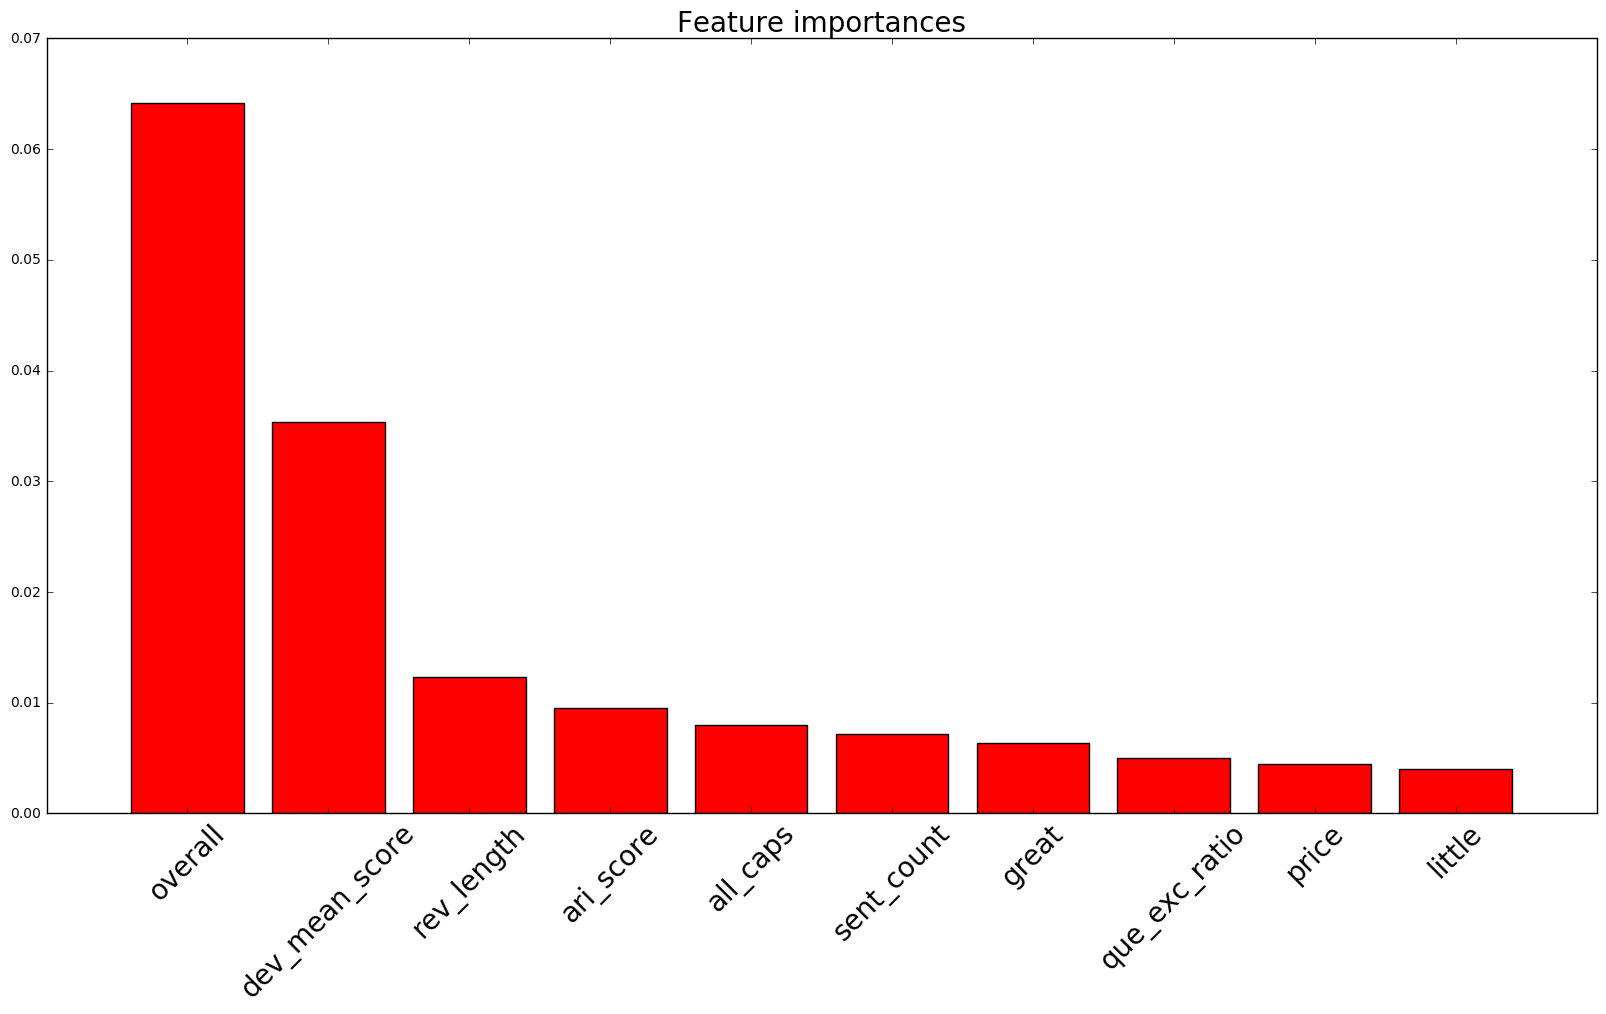

Feature ranking:
1. feature overall (0.064127)
2. feature dev_mean_score (0.035368)
3. feature rev_length (0.012315)
4. feature ari_score (0.009565)
5. feature all_caps (0.007983)
6. feature sent_count (0.007160)
7. feature great (0.006399)
8. feature que_exc_ratio (0.005005)
9. feature price (0.004439)
10. feature little (0.003979)


In [107]:
number = 10
importances = clrf.feature_importances_
#std = np.std([tree.feature_importances_ for tree in clsf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

#Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances", fontsize=20)
plt.bar(range(number), importances[indices[:number]],
       color="r", align="center")#, yerr=std[indices])
plt.xticks(range(number), temp_names, fontsize=20,rotation=45)
plt.xlim([-1, number])
plt.show()

# Print the feature ranking
print("Feature ranking:")

for f in range(number):
    print("%d. feature %s (%f)" % (f + 1,  feature_names[indices[f]], importances[indices[f]]))
